In [1]:
import os
# os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
# os.environ['CUDA_VISIBLE_DEVICES'] = "7"
# os.environ["MKL_NUM_THREADS"] = "4" 
# os.environ["NUMEXPR_NUM_THREADS"] = "4" 
# os.environ["OMP_NUM_THREADS"] = "4" 

import argparse
from torch.utils.data import Dataset
from torchvision import transforms
import torch
import torch.nn as nn

import numpy as np
import math
from dual_datasets import VIGORDataset
import PIL.Image
from PIL import ImageFile
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from training_utils import *

%load_ext autoreload
%autoreload 2

In [2]:
area = 'samearea'
ori_noise = 180.
ori_noise = 18 * (ori_noise // 18) # round the closest multiple of 18 degrees within prior 
pos_only = True
use_osm = True
use_adapt = False
training = False
use_concat=False

dataset_root='/work/vita/qngo/VIGOR'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(17)
np.random.seed(0)

transform_grd = transforms.Compose([
    transforms.Resize([320, 640]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
])

transform_sat = transforms.Compose([
    # resize
    transforms.Resize([512, 512]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
])

zero_ori = np.zeros(52605)

dataset = VIGORDataset(dataset_root, split=area, 
                     train=training, pos_only=pos_only, 
                     transform=(transform_grd, transform_sat), 
                     ori_noise=ori_noise, use_osm_tiles=use_osm, 
                     use_50_n_osm_tiles=use_adapt, 
                     use_concat=use_concat,
                     use_osm_rendered=True,
                     random_orientation=zero_ori)

loaded data pikle
osm tiles loaded for NewYork
InputData::__init__: load /work/vita/qngo/VIGOR/splits_new/NewYork/satellite_list.txt 23279
loaded data pikle
osm tiles loaded for Seattle
InputData::__init__: load /work/vita/qngo/VIGOR/splits_new/Seattle/satellite_list.txt 44055
loaded data pikle
osm tiles loaded for SanFrancisco
InputData::__init__: load /work/vita/qngo/VIGOR/splits_new/SanFrancisco/satellite_list.txt 68310
loaded data pikle
osm tiles loaded for Chicago
InputData::__init__: load /work/vita/qngo/VIGOR/splits_new/Chicago/satellite_list.txt 90618
Sat loaded, data size:90618
InputData::__init__: load  /work/vita/qngo/VIGOR/splits_new/NewYork/same_area_balanced_test.txt 13884
InputData::__init__: load  /work/vita/qngo/VIGOR/splits_new/Seattle/same_area_balanced_test.txt 25759
InputData::__init__: load  /work/vita/qngo/VIGOR/splits_new/SanFrancisco/same_area_balanced_test.txt 39866
InputData::__init__: load  /work/vita/qngo/VIGOR/splits_new/Chicago/same_area_balanced_test.txt

In [6]:
import os
base_model_path = '/work/vita/qngo/models/VIGOR/'
os.listdir(base_model_path)

['sat_only_seed1',
 'fused_image_with_image_loss',
 'samearea_HFoV360_samearea_lr_1e-04test_rendered_tile',
 'osm_concat_fusion',
 'fused_image_ccvpe_v2_adaptive_alpha_on_feature_only',
 'deformable_fusion_alpha0_correct_debug',
 'fused_image_ccvpe_v2_adaptive_alpha',
 'multiple3_deformable_attention_dropout',
 'lighter_deformable_attention',
 'multiple2_deformable_attention_pyramid_alpha_pos_no_skip',
 'fused_image_ccvpe_v2',
 'fused_image_encoder_v2_add_skip',
 'deformable_attention_pyramid_alpha_pos',
 'osm_non_rendered_tiles',
 'fused_image_ccvpe_v2_pretrained_efficientnet_frozen',
 'osm_only_seed1',
 'new_learnable_Q_self_and_cross',
 'osm_sat_feature_fusion',
 'score_stacked_debug',
 'deformable_fusion_alpha1',
 'CCVPE_W',
 'fused_image_base_logging',
 'CCVPE_W_L1',
 '2self_2cross',
 'deformable_attention_add',
 'fused_image_ccvpe_v2_pretrained_efficientnet_no_image_loss',
 'deformable_fusion_alpha0_correct',
 'multiple4_lighter_deformable_attention',
 'fused_image_ccvpe_v2_adapt

In [7]:
from fused_image_deformable_attention_model import CVM_VIGOR as CVM
selected_model = 'fused_image_ccvpe_v2_adaptive_alpha_no_image_loss_rerun'
select_epoch = str(5)

test_model_path = os.path.join(base_model_path, selected_model, select_epoch, 'model.pt')
torch.cuda.empty_cache()
CVM_modelda = CVM(device, ori_noise, use_adapt=use_adapt, use_concat=False)
CVM_modelda.load_state_dict(torch.load(test_model_path))
CVM_modelda.to(device)
CVM_modelda.eval()

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0


/tmp/2558720/ipykernel_1243629/4215076067.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  CVM_modelda.load_state_dict(torch.load(test_model_path))


CVM_VIGOR(
  (adapt_concat): Sequential(
    (0): Conv2d(6, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (adapt_50_n): Sequential(
    (0): Conv2d(50, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (grd_efficientnet): EfficientNet(
    (_conv_stem): Conv2dStaticCircularPadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): Sequential(
        (0): custom_nn_CircularPad2d()
        (1): ZeroPad2d((0, 0, 0, 1))
      )
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticCircularPadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): Sequential(
            (0): custom_nn_CircularPad2d()
            (1): ZeroPad2d((0, 0, 1, 1))
          )
        )
        (_bn1):

In [8]:
CVM_modelda.deformable_fusion.cross_da1.learnable_alpha

Parameter containing:
tensor(0., device='cuda:0', requires_grad=True)

In [9]:
def run_infer(idx, dataset, model):
    grd, sat, osm, gt, _, orientation, city, _ = dataset.__getitem__(idx)

    grd_feed = grd.unsqueeze(0)
    sat_feed = sat.unsqueeze(0)
    osm_feed = osm.unsqueeze(0)
    
    grd_feed = grd_feed.to(device)
    sat_feed = sat_feed.to(device)
    osm_feed = osm_feed.to(device)
    
    invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
    
    grd = invTrans(grd)
    sat = invTrans(sat)
    osm = invTrans(osm)
    
    alpha, fusion_image, logits_flattened, heatmap, ori, matching_score_stacked, matching_score_stacked2, matching_score_stacked3, matching_score_stacked4, matching_score_stacked5, matching_score_stacked6 = model(grd_feed, sat_feed, osm_feed)
    matching_score_max1, _ = torch.max(matching_score_stacked, dim=1, keepdim=True)
    matching_score_max2, _ = torch.max(matching_score_stacked2, dim=1, keepdim=True)
    matching_score_max3, _ = torch.max(matching_score_stacked3, dim=1, keepdim=True)
    matching_score_max4, _ = torch.max(matching_score_stacked4, dim=1, keepdim=True)
    matching_score_max5, _ = torch.max(matching_score_stacked5, dim=1, keepdim=True)
    matching_score_max6, _ = torch.max(matching_score_stacked6, dim=1, keepdim=True)
    alpha = alpha.cpu().detach().numpy().flatten()[0]
    print('alpha : ', alpha)
    fusion_image = invTrans(fusion_image.cpu().detach())
    # grd = grd.cpu().detach().numpy() 
    # sat = sat.cpu().detach().numpy() 
    gt = gt.permute(1, 2, 0)
    gt = gt.cpu().detach().numpy()
    print(gt.shape)
    loc_gt = np.unravel_index(gt.argmax(), gt.shape)
    
    
    orientation = orientation.permute(1, 2, 0).cpu().detach().numpy() 
    
    heatmap = torch.squeeze(heatmap, dim=0).permute(1, 2, 0)
    heatmap = heatmap.cpu().detach().numpy()
    loc_pred = np.unravel_index(heatmap.argmax(), heatmap.shape)
    ori = torch.squeeze(ori, dim=0).permute(1, 2, 0)
    ori = ori.cpu().detach().numpy()
    
    cos_pred_dense = ori[:, :, 0]
    sin_pred_dense = ori[:, :, 1]
    cos_pred, sin_pred = ori[loc_pred[0], loc_pred[1], :]
    
    cos_gt, sin_gt = orientation[loc_gt[0], loc_gt[1], :]
    a_acos_gt = math.acos(cos_gt)
    if sin_gt < 0:
        angle_gt = math.degrees(-a_acos_gt) % 360
    else: 
        angle_gt = math.degrees(a_acos_gt)

    return alpha, fusion_image, city, sat, osm, grd, heatmap, ori, loc_gt, angle_gt, loc_pred, sin_pred_dense, cos_pred_dense, sin_pred, cos_pred

In [10]:
def show_ground(grd):
    plt.figure(figsize=(8,12))
    plt.imshow(  grd.permute(1, 2, 0)  )
    plt.axvline(grd.size()[2]/2, color='g')
    plt.axis('off')

In [11]:
def show_image(sat, grd, heatmap, ori, loc_gt, angle_gt, loc_pred, sin_pred_dense, cos_pred_dense, sin_pred, cos_pred):
    # plt.figure(figsize=(8,12))
    # plt.imshow(  grd.permute(1, 2, 0)  )
    # plt.axvline(grd.size()[2]/2, color='g')
    # plt.axis('off')
    # plt.savefig('figures/'+area+'_'+str(idx)+'_grd_'+'.png', bbox_inches='tight', pad_inches=0)
    
    plt.figure(figsize=(6,6))
    plt.imshow(  sat.permute(1, 2, 0)  )
    plt.imshow(heatmap,  norm=LogNorm(vmax=np.max(heatmap)), alpha=0.4, cmap='Reds')
    plt.scatter(loc_gt[1], loc_gt[0], s=300, marker='^', facecolor='g', label='GT', edgecolors='white')
    plt.scatter(loc_pred[1], loc_pred[0], s=300, marker='*', facecolor='gold', label='Ours', edgecolors='white')
    xx,yy = np.meshgrid(np.linspace(0,512,512),np.linspace(0,512,512))
    cos_angle = ori[:,:,0]
    sin_angle = ori[:,:,1]
    # plt.quiver(xx[::40, ::40], yy[::40, ::40], -sin_pred_dense[::40, ::40], cos_pred_dense[::40, ::40], linewidths=0.2, scale=14, width=0.01) # plot the predicted rotation angle + 90 degrees
    plt.quiver(loc_pred[1], loc_pred[0], -sin_pred, cos_pred, color='gold', linewidths=0.2, scale=10, width=0.015)
    plt.quiver(loc_gt[1], loc_gt[0], -np.sin(angle_gt / 180 * np.pi), np.cos(angle_gt / 180 * np.pi), color='g', linewidths=0.2, scale=10, width=0.015)
    plt.axis('off')
    plt.legend(loc=2, framealpha=0.8, labelcolor='black', prop={'size': 15})

In [12]:
idx = 1
i = 0

894
alpha :  0.6053801
(512, 512, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.9670086..7.301481].


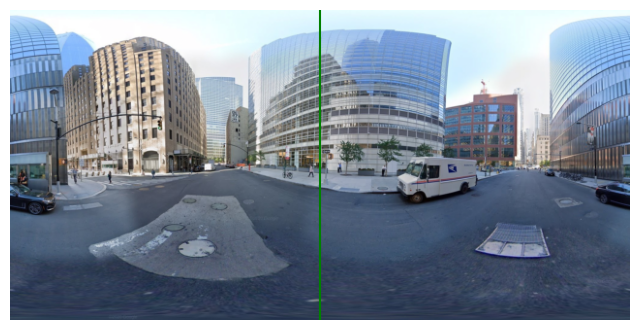

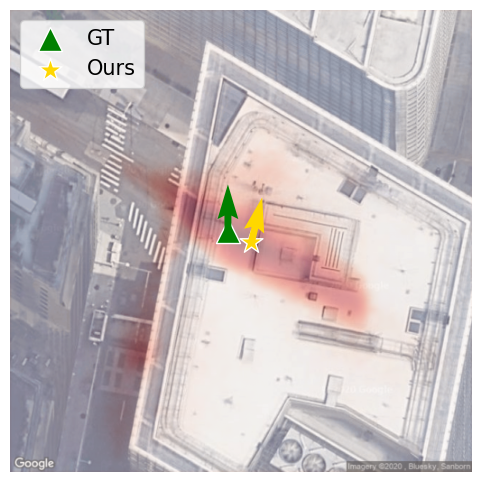

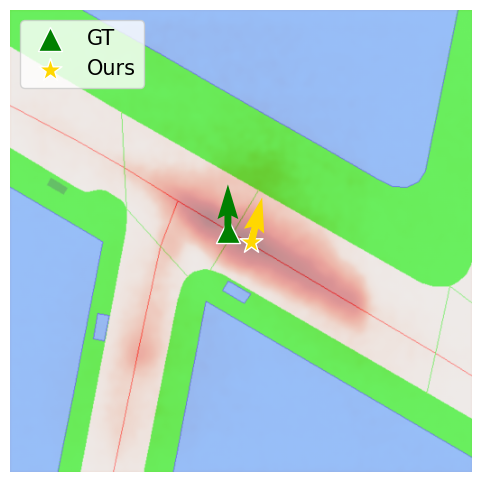

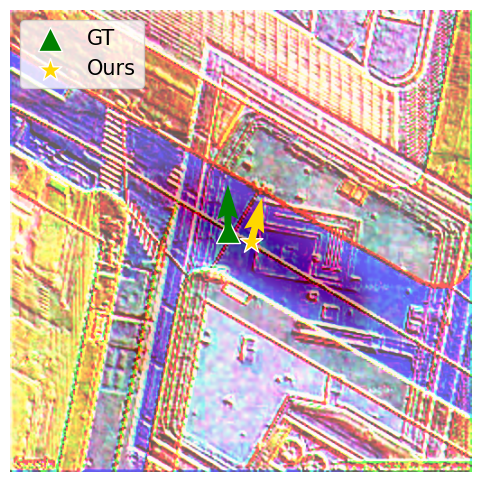

In [30]:
idx = 894
print(idx)
alpha, fusion_image, city, sat, osm, grd, heatmap, ori, loc_gt, angle_gt, loc_pred, sin_pred_dense, cos_pred_dense, sin_pred, cos_pred = run_infer(idx, dataset, CVM_modelda)
show_ground(grd)
show_image(sat, grd, heatmap, ori, loc_gt, angle_gt, loc_pred, sin_pred_dense, cos_pred_dense, sin_pred, cos_pred)
show_image(osm, grd, heatmap, ori, loc_gt, angle_gt, loc_pred, sin_pred_dense, cos_pred_dense, sin_pred, cos_pred)
show_image(fusion_image.squeeze(0), grd, heatmap, ori, loc_gt, angle_gt, loc_pred, sin_pred_dense, cos_pred_dense, sin_pred, cos_pred)


In [15]:
alphas = []
for i in range(1000):
    alpha, fusion_image, city, sat, osm, grd, heatmap, ori, loc_gt, angle_gt, loc_pred, sin_pred_dense, cos_pred_dense, sin_pred, cos_pred = run_infer(i, dataset, CVM_modelda)
    alphas.append(alpha)


alpha :  0.55468297
(512, 512, 1)
alpha :  0.55001414
(512, 512, 1)
alpha :  0.5383835
(512, 512, 1)
alpha :  0.49150288
(512, 512, 1)
alpha :  0.5306188
(512, 512, 1)
alpha :  0.53626096
(512, 512, 1)
alpha :  0.55900466
(512, 512, 1)
alpha :  0.54932725
(512, 512, 1)
alpha :  0.48132932
(512, 512, 1)
alpha :  0.54845375
(512, 512, 1)
alpha :  0.5613668
(512, 512, 1)
alpha :  0.5296186
(512, 512, 1)
alpha :  0.55142164
(512, 512, 1)
alpha :  0.52981806
(512, 512, 1)
alpha :  0.54515827
(512, 512, 1)
alpha :  0.5556675
(512, 512, 1)
alpha :  0.5922711
(512, 512, 1)
alpha :  0.5902443
(512, 512, 1)
alpha :  0.5329741
(512, 512, 1)
alpha :  0.5575951
(512, 512, 1)
alpha :  0.53916454
(512, 512, 1)
alpha :  0.52211297
(512, 512, 1)
alpha :  0.5127928
(512, 512, 1)
alpha :  0.42847282
(512, 512, 1)
alpha :  0.5866431
(512, 512, 1)
alpha :  0.5928918
(512, 512, 1)
alpha :  0.52224624
(512, 512, 1)
alpha :  0.56229365
(512, 512, 1)
alpha :  0.49676242
(512, 512, 1)
alpha :  0.52173173
(512, 

(array([ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,
         1.,  0.,  0.,  4.,  1.,  3.,  0.,  3.,  4.,  6.,  5.,  5.,  3.,
         2.,  5.,  2.,  2.,  7.,  2.,  3.,  7.,  8., 13., 13.,  8., 10.,
         9., 10., 13., 16., 17., 23., 21., 29., 22., 29., 21., 25., 35.,
        40., 27., 47., 41., 40., 39., 30., 45., 34., 32., 35., 26., 32.,
        20., 23., 21., 19., 11.,  7.,  8.,  7.,  6.,  4.,  3.,  3.,  1.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.33749378, 0.34061059, 0.34372741, 0.3468442 , 0.34996101,
        0.35307783, 0.35619465, 0.35931146, 0.36242828, 0.36554506,
        0.36866188, 0.3717787 , 0.37489551, 0.37801233, 0.38112915,
        0.38424593, 0.38736275, 0.39047956, 0.39359638, 0.3967132 ,
        0.39982998, 0.4029468 , 0.40606362, 0.40918043, 0.41229725,
        0.41541404, 0.41853085, 0.42164767, 0.42476448, 0.4278813 ,
        0.43099809, 0.4341

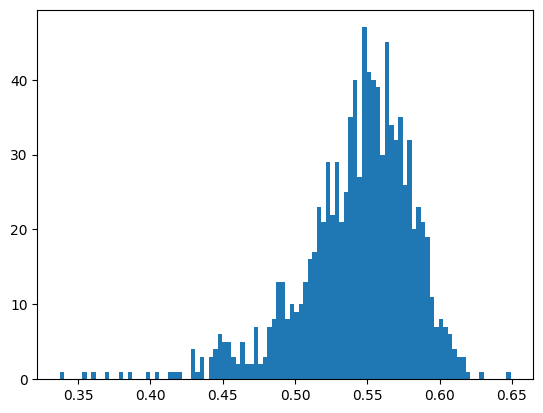

In [16]:
plt.hist(alphas, bins=100)

In [17]:
min_alpha = np.argmin(alphas)
min_alpha

np.int64(861)

In [18]:
a2 = alphas.copy()

In [28]:
n=20
ind = np.argpartition(alphas, -n)[-n:]


In [29]:
ind

array([894, 696, 623, 875, 276, 511, 379, 809, 363, 563, 434, 405, 709,
       935, 779, 657,  56, 742, 462, 107])

In [78]:
alphas[107]

np.float32(0.65613025)

In [23]:
stored_alphas = []
for i in [566, 524, 161, 796, 263, 861, 786, 706,  23, 582, 369, 933, 560, 179, 388, 394, 765, 158, 564, 440]:
    alpha, fusion_image, city, sat, osm, grd, heatmap, ori, loc_gt, angle_gt, loc_pred, sin_pred_dense, cos_pred_dense, sin_pred, cos_pred = run_infer(i, dataset, CVM_modelda)
    stored_alphas.append(alpha)

alpha :  0.40309075
(512, 512, 1)
alpha :  0.48544025
(512, 512, 1)
alpha :  0.4499612
(512, 512, 1)
alpha :  0.36999363
(512, 512, 1)
alpha :  0.35479617
(512, 512, 1)
alpha :  0.33749378
(512, 512, 1)
alpha :  0.46273664
(512, 512, 1)
alpha :  0.4639551
(512, 512, 1)
alpha :  0.42847282
(512, 512, 1)
alpha :  0.39880213
(512, 512, 1)
alpha :  0.42913562
(512, 512, 1)
alpha :  0.5073031
(512, 512, 1)
alpha :  0.4289812
(512, 512, 1)
alpha :  0.5080253
(512, 512, 1)
alpha :  0.44200832
(512, 512, 1)
alpha :  0.36179423
(512, 512, 1)
alpha :  0.43053406
(512, 512, 1)
alpha :  0.4570199
(512, 512, 1)
alpha :  0.38061017
(512, 512, 1)
alpha :  0.4799169
(512, 512, 1)


(array([4., 3., 4., 5., 4.]),
 array([0.33749378, 0.37160009, 0.40570638, 0.43981269, 0.47391897,
        0.50802529]),
 <BarContainer object of 5 artists>)

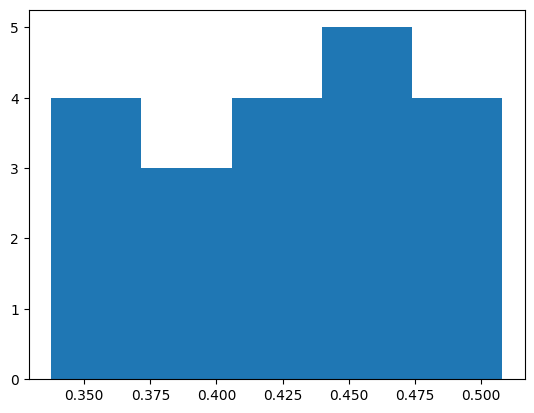

In [27]:
plt.hist(stored_alphas, bins=5)